# Test thicknes and storage for transien fdm wit water table (unconfined -  confined)

@ TO 20230220

To prevent oscillations and dry-cell problems with FDM models, the active thickness and storage coefficients have to be smooth when the head goes beyond the top or below the bottom of the model cells. A proven way to do this, is by using a function for the thickness when the actual thickness is less than say some $\epsilon$ and above the same $\epsilon$ below the top of the cells. Several functions may be suitable. But in any case to be smooth the regular and functional thckness have to be continuous at $\epsilon$

A simple function that fultulls this requirment is

$$ \delta = \epsilon e^\frac{z-\epsilon}\tau $$

$$ \frac{d\delta}{dz} = \frac\epsilon\tau e^\frac{x - \epsilon}{\tau} $$

When $z =\epsilon$ then $\delta = \epsilon$ and also $\frac {d\delta}{dz}|_{z=epsilon} = \frac\epsilon\tau$. Therefore, this function fulfills the requirements when $f' = \frac\epsilon\tau$ with $f'$ the desired derivative at $x=\epsilon$ which is $f'=1$ for thickness $z$. It follows that $\tau=\epsilon$ and
$$ \delta = \epsilon e^{\frac x\epsilon - 1}$$

The graphs below show that this function works just fine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, erfc

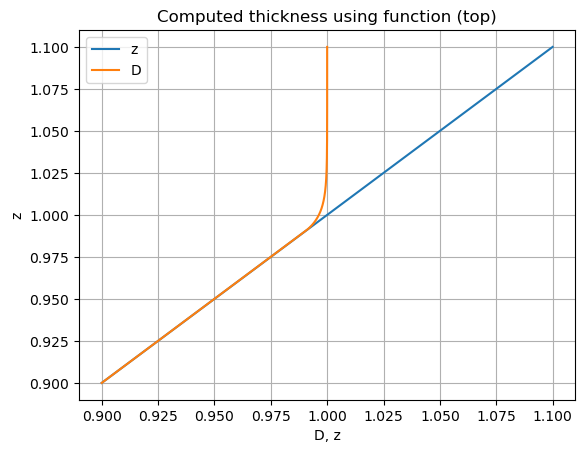

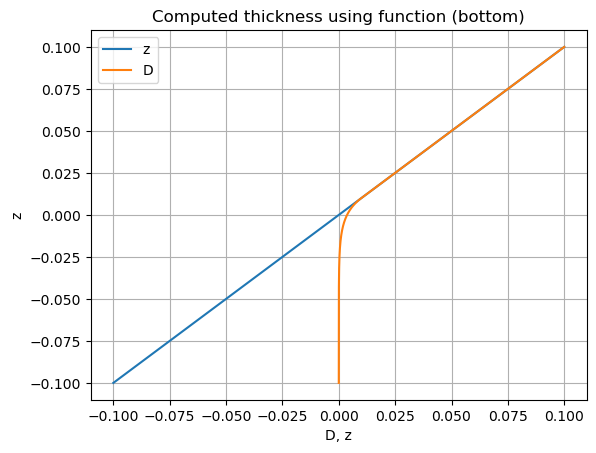

In [2]:
eps = 0.01
H = 1.0
z1 = np.linspace(-0.1, 0.1, 2001)
z2 = np.linspace(H - 0.1, H + 0.1, 2001)
delta = lambda z: eps * np.exp(z / eps - 1)
D1 = z1.copy(); D1[z1 < eps] = delta(z1[z1 < eps]); D1[z1 > H - eps] = H - delta(H - z1[z1 > H - eps])
D2 = z2.copy(); D2[z2 < eps] = delta(z2[z2 < eps]); D2[z2 > H - eps] = H - delta(H - z2[z2 > H - eps])

plt.title("Computed thickness using function (top)")
plt.xlabel('D, z')
plt.ylabel('z')
plt.plot(z2, z2, label='z')
plt.plot(D2, z2, '-', label='D')
plt.grid()
plt.legend()
plt.show()

plt.title("Computed thickness using function (bottom)")
plt.xlabel('D, z')
plt.ylabel('z')
plt.plot(z1, z1, label='z')
plt.plot(D1, z1, '-', label='D')
plt.grid()
plt.legend()
plt.show()

Can we do the same for the storage coefficient?

When $D$ as computed above remains between 0 and H, then we have for the elastic storage coefficient

$$S = S_s D$$

The water table storage should $S_y$ for D between 0 and H. It could gradually grow to 1 when $z < \epsilon$ and reduce to zero when $z > H - \epsilon$ 

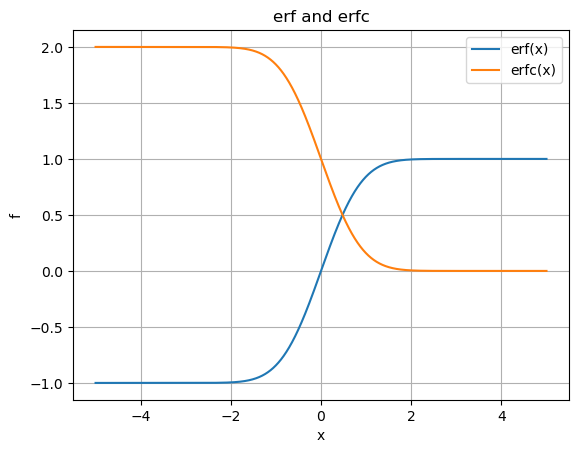

In [3]:
x = np.linspace(-5, 5, 5001)
plt.title("erf and erfc")
plt.ylabel('f')
plt.xlabel('x')
plt.grid()
plt.plot(x, erf(x), label='erf(x)')
plt.plot(x, erfc(x), label='erfc(x)')
plt.legend()
plt.show()

The erf function is most useful. What is the derivative at $x=0$?

$$ \mathrm{erf}(x) = \frac 2 {\sqrt{\pi}} \intop_0^x e^{-t ^2} dt $$

$$ \frac{d \, \mathrm{erfc} (x)}{dx} = \frac 2 {\sqrt{\pi}} e^{-x^2} $$

And for $x=0$, $\frac{d \, \mathrm{erfc} (x)}{dx}|_{x=0} = \frac 2 {\sqrt{\pi}} $.

We can make it sharper by using $\sigma$ to scale $x$

$$ \mathrm{erf}(x) = \frac 2 {\sqrt{\pi}} \intop_0^x e^{-\frac {t^2}{\sigma^2}} dt $$

$$ \frac{d \, \mathrm{erfc} (x)}{dx} = \frac {2 \sigma} {\sqrt{\pi}} e^{-\frac{x^2} {\sigma^2}} $$

And for $x=0$, $\frac{d \, \mathrm{erfc} \left(\frac x {\sigma} \right)}{dx}|_{x=0} = \frac {2 \sigma} {\sqrt{\pi}} $.

Hence, by choosing $\sigma$ we can make the gradient at $x=0$ as steep as we'd like.

TO let the storage coefficient grow from zero to $S_y$ we will use $f = \frac {S_y} 2 \mathrm{erfc}\left(1 + \frac x \sigma\right)$

Or, with {z} the relative vertical coordinate in the cell

$$ f = \frac {S_y} 2 \mathrm{erfc}\left(1 + \frac x \sigma\right)$$

for the bottom of the cell and

$$ f = \frac {S_y} 2 \mathrm{erfc}\left(1 + \frac {H - x} \sigma\right)$$

for the top of the cell.

Clearly $\sigma$ is the standard deviation of the statistical distribution $\mathrm{erf}(x)$. In our case, a good value to smooth $S_y$ would be $\sigma = 0.01$ m.



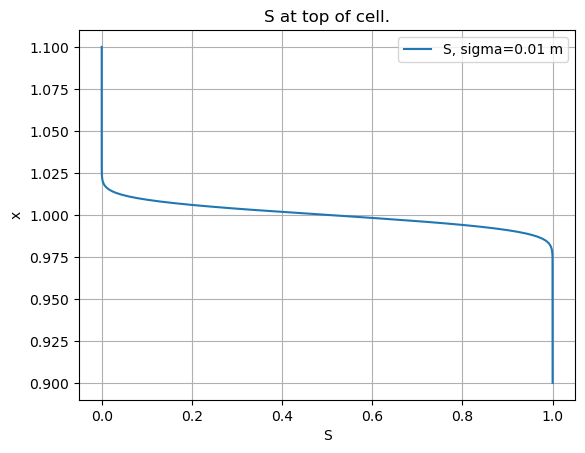

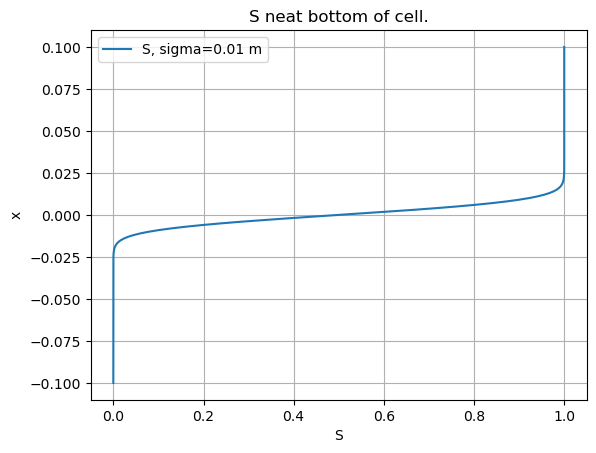

In [4]:
x1 = np.linspace(-0.1, 0.1, 201)
x2 = np.linspace(0.9, 1.1, 201) * H
sigma = 0.01
S = lambda x: 0.5 * (erf(x / sigma) + 1)

plt.title("S at top of cell.")
plt.xlabel('S')
plt.ylabel('x')
plt.grid()
plt.plot(S(H - x2), x2, label='S, sigma={:.2f} m'.format(sigma))
plt.legend()
plt.show()

plt.title('S neat bottom of cell.')
plt.xlabel('S')
plt.ylabel('x')
plt.grid()
plt.plot(S(x1), x1, label='S, sigma={:.2f} m'.format(sigma))
plt.legend()
plt.show()

Implementatie in het model.

Dit kan mogelijk het beste door dit te delegeren aan het grid object.

In [5]:

def DZtol(self, phi, tol=0.01):
    """Return active layer thickness dependent on actual phi.

    Returns the effective cell thickness which will be close to zero for head near or below
    cel bottom and close to cell top for heads near or above cell top and the actual wet
    thickness for heads between top - tol and bot + tol. This make sure that cells
    will never run completely dry.

    Parameters
    ----------
    phi: np.ndarray
        head as a 3D array of cells.
    tol: float
        thicknes of layer close to bottom and top of cell where smoothing of cell thickness starts.
    """
    delta = lambda t: tol * np.exp(t / self.tol)
    D = phi - self.Z[1:]
    d_top = self.Z[:-1]- phi
    d_bot = phi - self.Z[1:]
    D[d_top < tol] = self.DZ[d_top < tol] - delta(D[d_top < tol])
    D[d_bot < tol] = delta(D[d_bot < tol])
    return D

def Sy_tol(self, phi, sigma=0.01):
    """Return specific yield taking layer wetness into account.

    Function Sy / 2 (1 + erf(x / simga)) is used

    Parameters
    ----------
    phi: np.ndarray
            head as a 3D array of cells.
    sigma: float
        standard dev for erfc function determining the steepness around top and bottom of the cell.
    """
    zm = phi - 0.5 * (self.Z[:-1] + self.Z[1:])
    d = phi - zm
    Sy = self.Sy()
    Sy[d > 0.] = Sy[d > 0.] / 2. * (1 + erf(+d / sigma))
    Sy[d < 0.] = Sy[d < 0.] / 2. * (1 + erf(-d / sigma))
    return Sy

## What is the length along the cruve of $\exp(-x)$ compared to $x$?

This question arises for istance when the surface subsides near a vertical face and obtains an exponentially like curvature. Then the fault between the surace at ground surface and the vertical wall is determined by the new length of the curvature compared to the old one:

$$ s = \intop_0^x \frac{1}{\cos\left(e^{-\xi}\right)} d\xi $$

As Wolfrand integration website does not provide a sutable answer we will do a numerical comutation instead.

/var/folders/90/m51x_b713y561gzh2kzy18d00000gq/T/ipykernel_79025/2185771938.py:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, L / x, label="L/x")


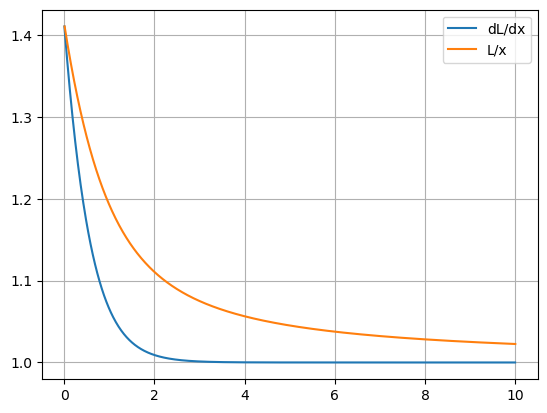

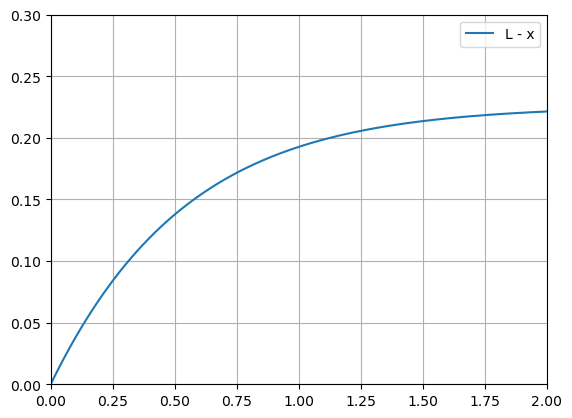

In [20]:
x = np.linspace(0, 10, 1001)
dx = np.diff(x)
xm = 0.5 * (x[:-1] + x[1:])
ym = 1 / np.cos(np.arctan(-np.exp(-xm)))
L = np.hstack((0, np.cumsum(ym * dx)))

plt.plot(xm, ym, label="dL/dx")
plt.plot(x, L / x, label="L/x")
plt.grid()
plt.legend()
plt.show()

#plt.plot(x, x, label="L")
plt.plot(x, L - x, label="L - x")
plt.grid()
plt.xlim(0, 2)
plt.ylim(0, 0.3)
plt.legend()
plt.show()

In [11]:
1/np.cos(np.arctan(np.exp(0)))

1.414213562373095